This is a notebook to run ML inference on all 6 months of spire data using the trained xgboost model

* 6 months of spire data feature sets created by `/scripts/make_feature_sets_all_data.py`
* feature sets at `/data/feature_sets_all/`
* Model created by `/notebooks/ml-pipeline.multi.ipynb`
* Model stored at `/models4-multi-class_xgb-model.joblib` 


Goals:
* characterize 6 months of data
* Iono
    * distribution
    * detection in presense of RFI

* RFI
    * distribution of downlinks
        * detection of RFI in downlinks
    * distribution of RFI not during downlink

In [1]:
import xarray as xr
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal 
from sklearn.decomposition import PCA
import argparse
import pandas as pd

import sys  
sys.path.insert(1, '/home/stdi2687/gnss-leo-data/scripts')

from feature_extract_util import *
from ml_util import *

In [41]:
from matplotlib.patches import Rectangle
def plot_leo_ml_multi(sample, ds, lv2, y_pred, times, labels):

    c=299792458 #m/s
    #iono_free=((ds.scnfreq1**2)*(c/ds['exL1'])-(ds.scnfreq2**2)*(c/ds['exL2']))/(ds.scnfreq1**2-ds.scnfreq2**2)
    
    #ku=40.3*1e16
    #dTEC=(ds['exL2']-ds['exL1'])/(ku*(1/ds.scnfreq1**2-1/ds.scnfreq2**2))
    fig,ax=plt.subplots(6, figsize=(8,8),sharex=True)
    ax[0].set_title(sample)

    for freq,snr,color in zip([1,2],['caL1Snr','pL2Snr'],['#1b9e77','#d95f02']): 
        ax[0].plot(ds[snr].time+ds.startTime, ds[snr].values, alpha=.5, color=color, label='L%s'%freq)
        ax[0].set_ylabel('SNR' "\n" '(v/v)')

        ax[1].plot(lv2['s4_L%s'%freq].time+lv2.startTime, lv2['s4_L%s'%freq].values, color=color)
        ax[1].set_ylabel('S4')
        
        #ax[1].plot(ds['raw_exL%s'%freq].time, ds['raw_exL%s'%freq].values, color=color, label='L%s'%freq)
        #ax[1].set_ylabel(r'$\delta \phi$ (cycles)')
        ax[4].plot(lv2['elevation'].time+lv2.startTime, lv2['elevation'].values, color='black')
        ax[4].set_ylabel('elevation')
        ax2=ax[4].twinx()
        ax2.plot(ds['occheight'].time+ds.startTime, ds['occheight'].values, color='tab:orange')
        ax2.set_ylabel('occ height', color='tab:orange')

            
        ax[2].plot(ds['exL%s'%freq].time+ds.startTime, ds['exL%s'%freq].values, color=color, label='L%s'%freq)
        ax[2].set_ylabel(r'$\delta \phi$' "\n" '(m)')

        ax[3].plot(lv2['sigma_phi_L%s'%freq].time+lv2.startTime, lv2['sigma_phi_L%s'%freq].values, color=color)
        ax[3].set_ylabel(r'$\sigma \phi$' "\n" '(m)')
    #ax[3].plot(dTEC.time, dTEC.values)
    
    #ax[3].set_ylabel(r'$\Delta TEC$' "\n" '(TECU)')
    
    #ax[4].plot(iono_free.time, iono_free.values)
    #ax[4].set_ylabel('iono-free' "\n" '(m)')
    ax[0].legend(ncol=2)
    '''
    ## plot ml results
    df=pd.read_pickle('/home/kawu4468-copy/data_mat/spire_iq/rf_ml_ro.pkl')
    colors=['#e7298a','#d95f02','#7570b3','#1b9e77','#1b9e77','#66a61e','#e6ab02'] ##1b9e77
    labels=['scint', 'OA', 'dual int', 'quiet', 'quiet', 'l1 int', 'l2 int']
    fn_arr='scnPhs_%s.0001_ex.mat' %sample
    df=df[df.file==fn_arr]
    print(df['sample'])
    print(df.y_pred)
    [ax[5].add_patch(Rectangle((ds.time.min()+i*15, 0), 15, 1, alpha=.75, color= ,  label=labels[y-1])) for i, y in list(zip(df['sample'], df.y_pred))]
    '''
    
    for valz, labz, colz in zip (np.arange(6),labels,['#e41a1c','white','#4daf4a','#984ea3','#ff7f00','#ffff33']): #377eb8
        #[ax[5].add_patch(Rectangle((i, 0), 15, 1, alpha=1, label='No Scint', color="white")) for i in times[y_pred==0]]
        [ax[5].axvline(i) for i in times]
        [ax[5].add_patch(Rectangle((i, 0), 15, 1, alpha=.75, label=labz, color=colz)) for i in times[y_pred==valz]]
    
    handles,labels_=ax[5].get_legend_handles_labels() #get existing legend item handles and labels
    by_label = dict(zip(labels_, handles))
    ax[5].legend(by_label.values(), by_label.keys(), ncol=4, loc='lower left')
    ax[5].get_yaxis().set_ticks([])
    ax[5].set_ylabel('RF Class')

    ax[5].set_xlim([times.min(), times.max()])

    #ax2=ax[5].twinx()
    #ax2.plot(ds['RFI'].orbtime-ds['RFI'].orbtime[0]+ds.startTime, ds['RFI'].values, color='tab:orange')
    #ax2.plot(hour_init+(ds['RFI'].orbtime-ds.startTime.values[0])/3600, ds['RFI'].values)
    #ax2.set_ylabel('RFI')
    #plt.savefig("../figures/results/%s.png" %sample, dpi=300)

def load_plot_multi(sample):
    labels=['Scint','Quiet','RFI','Artifact','Severe Scint'] #'oa',

    sample=sample[:-4]

    #feature_pkl='../data/feature_sets_all/%s.pkl' %sample
    import os.path
    fn='/media/datastore/mirror/spwxdp/repro4/spire/level1b/scnPhs/%s/scnPhs_%s.0001_nc'%(sample[:8],sample)
    lv1=load_leo(fn)
    fn='/media/datastore/mirror/spwxdp/repro4/spire/level2/scnLv2/%s/scnLv2_%s.0001_nc'%(sample[:8],sample)
    lv2=load_leo(fn)

    #plot_leo(sample, sp, lv2)
    fdf=extract_fs(lv1,lv2)
    fdf['sample']=len(fdf)*[sample]


    X, y, feature_names, fs_dict=df_2_Xy(fdf)
    #--- test model
    y_pred = rf_model.predict(X)

    plot_leo_ml_multi(sample, lv1, lv2, y_pred, fs_dict['time'], labels)

def map_condition(lons, lats, y_pred, condition_val):
    #https://medium.com/@kavee625/plotting-data-on-the-world-map-with-geopandas-f03742615196
  import matplotlib.pyplot as plt
  import geopandas as gpd
  #from cartopy import crs as ccrs
  # Getting world map data from geo pandas
  worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

  # Creating axes and plotting world map
  fig, ax = plt.subplots(figsize=(16, 10))
  worldmap.plot(color="lightgrey", ax=ax)

  #robinson = ccrs.Robinson().proj4_init
  #worldmap.to_crs(robinson).plot(color="lightgrey", ax=ax)

  # Plotting tourist source markets
  x = lons[y_pred==condition_val]
  y = lats[y_pred==condition_val]
  #z = df['spireid']
  plt.scatter(x, y, 
                s=0.2,#*z,
                c='b',
                alpha=0.3,             
                cmap='autumn'
              )
  #plt.colorbar(label='Number of tourists')

  # Creating axis limits and title
  plt.xlim([-180, 180])
  plt.ylim([-90, 90])

  #plt.title("Tourist arrivals from main countries to Sri Lanka\n  Year : 2021")
  plt.xlabel("Longitude")
  plt.ylabel("Latitude")
  plt.show()

In [13]:


'''
#list all files
def list_all_files(parent_directory):
    file_list = []
    for root, dirs, files in os.walk(parent_directory):
        for file in files:
            file_list.append(file)
    return file_list

parent_directory = '/media/datastore/mirror/spwxdp/repro4/spire/level1b/scnPhs'
all_files = list_all_files(parent_directory)

print(len(all_files))
'''
#list all feature sets

parent_directory = '/home/stdi2687/gnss-leo-data/data/feature_sets_all'
all_files_f = os.listdir(parent_directory)

print(len(all_files_f))
print(all_files_f[:2])


fdf_li=[]
for filez in all_files_f[:]:
    #print(row['c1'], row['c2'])
    fn="../data/feature_sets_all/%s" %filez
    fn="../data/feature_sets_all_v2/%s" %filez
    sample=filez[:-4]
    #print(fn)
    
    try:
        if filez[:]
        fdf=pd.read_pickle(fn)
        fdf['sample']=len(fdf)*[sample]
        fdf_li+=[fdf]
    except:
        pass
all_fdf=pd.concat(fdf_li, axis=0, ignore_index=True)

#X, y, times, lats, occ_hts, feature_names =df_2_Xy(all_fdf)
#X, y, feature_names, fs_dict=df_2_Xy(all_fdf)

54966
['2023.104.122.08.01.R07.SC001_0001.pkl', '2022.310.129.14.01.G31.SC001_0001.pkl']


In [3]:
#save for later
#all_fdf.to_pickle('../data/feature_set_all_single_file/all_fdf_v2.pkl')

#read later
all_fdf=pd.read_pickle('../data/feature_set_all_single_file/all_fdf_v2.pkl')
#X, y, times, lats, lons, occ_hts, feature_names =df_2_Xy(all_fdf)
X, y, feature_names, fs_dict=df_2_Xy(all_fdf)

parent_directory = '/home/stdi2687/gnss-leo-data/data/feature_sets_all'
all_files_f = os.listdir(parent_directory)

In [4]:
version="4-multi-class"
version="6"
version="7"
from joblib import dump, load
rf_model=load( '../models/%s_rf-model.joblib' %version)


#--- test model
y_pred = rf_model.predict(X)
#print(y_pred)
unique, counts = np.unique(y_pred, return_counts=True)
count_dict=dict(zip(unique, counts))
print(count_dict)

{0.0: 153342, 1.0: 452001, 2.0: 14156, 3.0: 7197, 4.0: 37259}


In [5]:
for keyz in list(count_dict.keys()):
    print('label',keyz, ':', count_dict[keyz]/len(y_pred))

label 0.0 : 0.2309523988824544
label 1.0 : 0.6807705341476455
label 2.0 : 0.02132072203688503
label 3.0 : 0.01083959003245702
label 4.0 : 0.05611675490055802


# filter triggered vs campaign

In [27]:
campaign_ind=[i for i, si in enumerate(fs_dict['sample']) if si.startswith("2023.14")]

# Lists for Ann

In [28]:
fs_df=pd.DataFrame(fs_dict)
fs_df['y_pred']=y_pred

In [29]:
#campaign profiles
camp_df=fs_df.iloc[campaign_ind]
camp_y=y_pred[campaign_ind]

unique, counts = np.unique(camp_y, return_counts=True)
count_dict=dict(zip(unique, counts))
print(count_dict)

for keyz in list(count_dict.keys()):
    print('label',keyz, ':', count_dict[keyz]/len(camp_y))

camp_df[camp_y==2].drop_duplicates(subset='sample', keep="first").to_csv('../data/rfi_labels_camp.csv', index=False)
camp_df[camp_y==0].drop_duplicates(subset='sample', keep="first").to_csv('../data/iono_labels_camp.csv', index=False)

trigger_df=fs_df.drop(index=campaign_ind)
mask = np.ones(y_pred.size, dtype=bool)
mask[campaign_ind] = False
trigger_y=y_pred[mask]

unique, counts = np.unique(trigger_y, return_counts=True)
count_dict=dict(zip(unique, counts))
print(count_dict)

for keyz in list(count_dict.keys()):
    print('label',keyz, ':', count_dict[keyz]/len(trigger_y))

trigger_df[trigger_y==2].drop_duplicates(subset='sample', keep="first").to_csv('../data/rfi_labels_trig.csv', index=False)
trigger_df[trigger_y==0].drop_duplicates(subset='sample', keep="first").to_csv('../data/iono_labels_trig.csv', index=False)


{0.0: 5298, 1.0: 113128, 2.0: 867, 3.0: 334, 4.0: 255}
label 0.0 : 0.0441934568992843
label 1.0 : 0.9436612669124639
label 2.0 : 0.007232111576383444
label 3.0 : 0.00278607297175556
label 4.0 : 0.0021270916401127777
{0.0: 157205, 1.0: 330958, 2.0: 13095, 3.0: 11786, 4.0: 36203}
label 0.0 : 0.28621913273991484
label 1.0 : 0.6025667868918719
label 2.0 : 0.023841732408187936
label 3.0 : 0.02145846950461268
label 4.0 : 0.06591387845541259


In [56]:
# plot rates for different data regimes

# Maps

/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


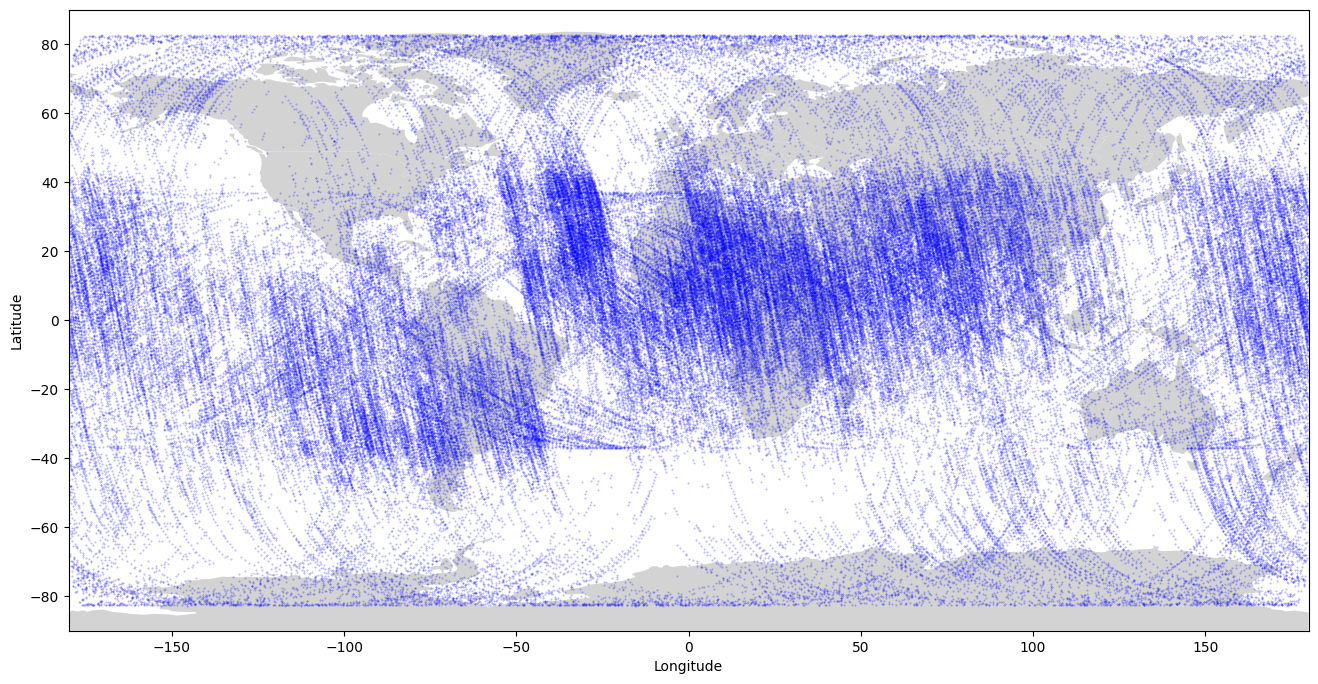

In [7]:
map_condition(fs_dict['lon_m'], fs_dict['lat_m'], y_pred, 0)

/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


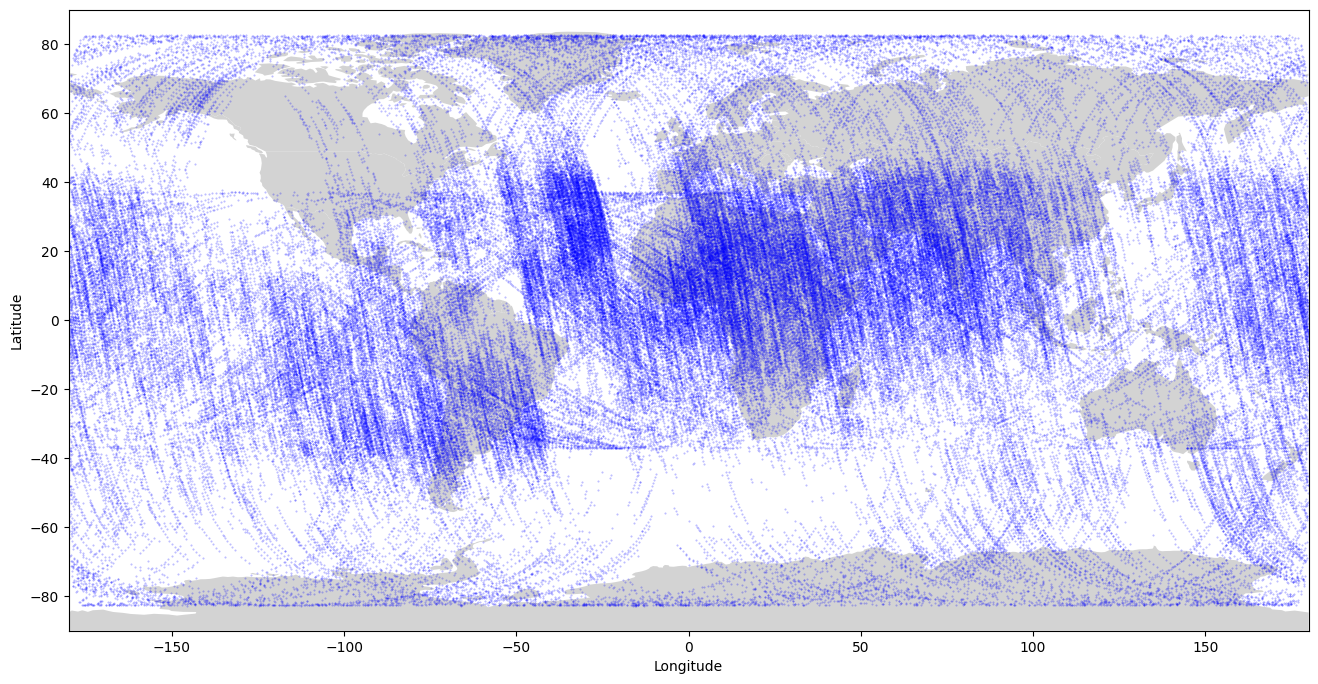

In [15]:
map_condition(fs_dict['lon_m'][mask], fs_dict['lat_m'][mask], trigger_y, 0)

In [18]:
import math
def ecef2lla(x,y,z):
    a = 6378137
    e = 8.1819190842622e-2

    b = math.sqrt(math.pow(a,2)*(1-math.pow(e,2)))
    ep = math.sqrt((math.pow(a,2)-math.pow(b,2))/math.pow(b,2))
    p = math.sqrt(math.pow(x,2)+math.pow(y,2))
    th = math.atan2(a*z,b*p)
    lon = math.atan2(y,x)
    lat = math.atan2((z+math.pow(ep,2)*b*math.pow(math.sin(th),3)),(p-math.pow(e,2)*a*math.pow(math.cos(th),3)))
    N = a/math.sqrt(1-math.pow(e,2)*math.pow(math.sin(lat),2))
    alt = p/math.cos(lat)-N

    lon=math.degrees(lon)
    lat=math.degrees(lat)


    return (lat,lon,alt)
(lat,lon,alt)=ecef2lla(fs_dict['xLeo_m'][0],fs_dict['yLeo_m'][0],fs_dict['zLeo_m'][0])

In [21]:
vfunc = np.vectorize(ecef2lla)
lat,lon,alt=vfunc(fs_dict['xLeo_m'], fs_dict['yLeo_m'],fs_dict['zLeo_m'])


In [26]:
fs_dict

{'time': array([1.36549663e+09, 1.36549662e+09, 1.36549660e+09, ...,
        1.35952809e+09, 1.35952807e+09, 1.35952806e+09]),
 'lat_m': array([ 2.55674665,  3.51623358,  4.47571348, ..., 43.99039277,
        43.05226159, 42.11347634]),
 'lon_m': array([  27.82982874,   28.01684798,   28.20412493, ..., -137.19295735,
        -136.89627732, -136.60661159]),
 'occheight_m': array([ 71.99910844,  92.59665898, 112.80402757, ..., 300.08420053,
        322.278504  , 343.22312361]),
 'xLeo_m': array([6823.43022767, 6817.46670405, 6809.58199137, ..., -630.80983263,
        -661.02702073, -691.0617311 ]),
 'yLeo_m': array([ -76.38715157,  -61.5232109 ,  -46.64194131, ..., 4917.33499608,
        4991.28828895, 5063.86381393]),
 'zLeo_m': array([ 302.79612257,  416.30444447,  529.69512843, ..., 4756.23299103,
        4674.5051838 , 4591.48345977]),
 'xGnss_m': array([-3102.47038238, -3134.09636604, -3165.70545589, ...,
        -1045.32602431,  -996.5368894 ,  -947.74295454]),
 'yGnss_m': array([-

In [17]:
import pyproj

transformer = pyproj.Transformer.from_crs(
    {"proj":'geocent', "ellps":'WGS84', "datum":'WGS84'},
    {"proj":'latlong', "ellps":'WGS84', "datum":'WGS84'},
    )
x = fs_dict['xLeo_m'][0]
y = fs_dict['yLeo_m'][0]
z = fs_dict['zLeo_m'][0]
lon1, lat1, alt1 = transformer.transform(x,y,z,radians=False)
print (lat1, lon1, alt1 )

90.0 -0.6413898036175608 -6356449.518122607


In [24]:
# For all Downlinks, count occurence of RFI (ability to detect downlink)
# For all downlinks, count occurence of iono (ability to do science during DL)

In [9]:
consat_df=pd.read_pickle("../data/consat_df.pkl")

In [10]:
#generate list of comms link profiles
comms_file_li=[]

for index, row in consat_df.iloc[:].iterrows():
    start_t=row['start']
    end_t=row['end']
    spireid=row['spire_id']
    contacttype=row['contact_type']
    #gnssid=
    row=row.drop('sum_all')
    idx_sv=row.iloc[4:].gt(0)
    for idx,val in row.iloc[4:][idx_sv].iteritems():
        #print(idx, val)
        gnssid=idx
        
        sample='%s.%03d.%s.%02d.01.%s.SC001_0001' %(start_t.year,start_t.day_of_year,spireid, start_t.hour,gnssid)
        #sample='2023.144.103.01.01.E33.SC001_0001'
        fn1='/media/datastore/mirror/spwxdp/repro4/spire/level1b/scnPhs/%s/scnPhs_%s.0001_nc'%(sample[:8],sample)
        #either 01 or 02
        if not os.path.isfile(fn1):
            sample='%s.%03d.%s.%02d.02.%s.SC001_0001' %(start_t.year,start_t.day_of_year,spireid, start_t.hour,gnssid)
            fn1='/media/datastore/mirror/spwxdp/repro4/spire/level1b/scnPhs/%s/scnPhs_%s.0001_nc'%(sample[:8],sample)
            if not os.path.isfile(fn1):
                continue
        comms_file_li.append('%s'%sample +'.pkl')

#drop duplicates
comms_file_li=list(set(comms_file_li))


In [33]:
len(comms_file_li)

11701

# check Downlink Windows

In [38]:
rfi_count=0
iono_rfi_count=0
scint_count=0
iono_rfi_li=[]
fdf_li=[]
comms_fdf_li=[]
for filez in comms_file_li[:]:
    #print(row['c1'], row['c2'])
    fn="../data/feature_sets_all/%s" %filez
    #print(fn)
    
    try:
        comms_fdf=pd.read_pickle(fn)
        if comms_fdf.shape[1]==63:
            comms_fdf['sample']=len(comms_fdf)*[sample]
            #X, y, times, lats, lons, occ_hts, feature_names =df_2_Xy(comms_fdf)
            X, y, feature_names, fs_dict=df_2_Xy(comms_fdf)

            #--- test model
            y_pred = rf_model.predict(X)

            # Was RFI detected during downlink? count
            if 2 in y_pred: 
                #print("exist")
                rfi_count+=1
                # Was IONO detected NEXT TO RFI?
                if 0 in y_pred:  #list contains both
                    #print(y_pred)
                    for i,element in enumerate(y_pred): #now loop through list
                        if i==0:
                            if (element==0 and (y_pred[i+1]==2)):
                                iono_rfi_count+=1
                                iono_rfi_li.append(filez)
                                continue #don't check the same array twice
                        if i==(len(y_pred)-1):
                            if (element==0 and (y_pred[i-1]==2)):
                                iono_rfi_count+=1
                                iono_rfi_li.append(filez)
                                continue #don't check the same array twice
                        if (i<=(len(y_pred)-2) and i!=0):
                            #print(i,len(y_pred))
                            if (element==0 and (y_pred[i-1]==2 or y_pred[i+1]==2)):
                                iono_rfi_count+=1
                                iono_rfi_li.append(filez)
                                continue #don't check the same array twice
            # Was scint detected during downlink at all?
            if 0 in y_pred:
                scint_count+=1
            comms_fdf_li+=[comms_fdf]
        else:
            print(fn, comms_fdf.shape[1])
        #print(i)
    except Exception as e:
        print(e)
        pass
#all_fdf=pd.concat(fdf_li, axis=0, ignore_index=True)

#X, y, times, lats, occ_hts, feature_names =df_2_Xy(all_fdf)

9
18
[Errno 2] No such file or directory: '../data/feature_sets_all/2023.041.115.04.01.G12.SC001_0001.pkl'
13
11
Found array with 0 sample(s) (shape=(0, 15)) while a minimum of 1 is required by StandardScaler.
13
12
Found array with 0 sample(s) (shape=(0, 15)) while a minimum of 1 is required by StandardScaler.
28
11
Found array with 0 sample(s) (shape=(0, 15)) while a minimum of 1 is required by StandardScaler.
10
11
[Errno 2] No such file or directory: '../data/feature_sets_all/2023.065.132.19.01.G10.SC001_0001.pkl'
21
11
[Errno 2] No such file or directory: '../data/feature_sets_all/2023.088.120.15.01.G18.SC001_0001.pkl'
16
13
Found array with 0 sample(s) (shape=(0, 15)) while a minimum of 1 is required by StandardScaler.
17
17
[Errno 2] No such file or directory: '../data/feature_sets_all/2023.034.129.23.01.R14.SC001_0001.pkl'
18
14
Found array with 0 sample(s) (shape=(0, 15)) while a minimum of 1 is required by StandardScaler.
18
21
[Errno 2] No such file or directory: '../data/fe

In [20]:
iono_rfi_count

2

In [21]:
scint_count

51

In [39]:
print(iono_rfi_count/len(comms_file_li))
print(rfi_count/len(comms_file_li)) 
print(scint_count/len(comms_file_li))

0.018716349029997435
0.35253397145543114
0.4385095291000769


0.3327066062729681

In [7]:
len(comms_file_li)

11701

/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


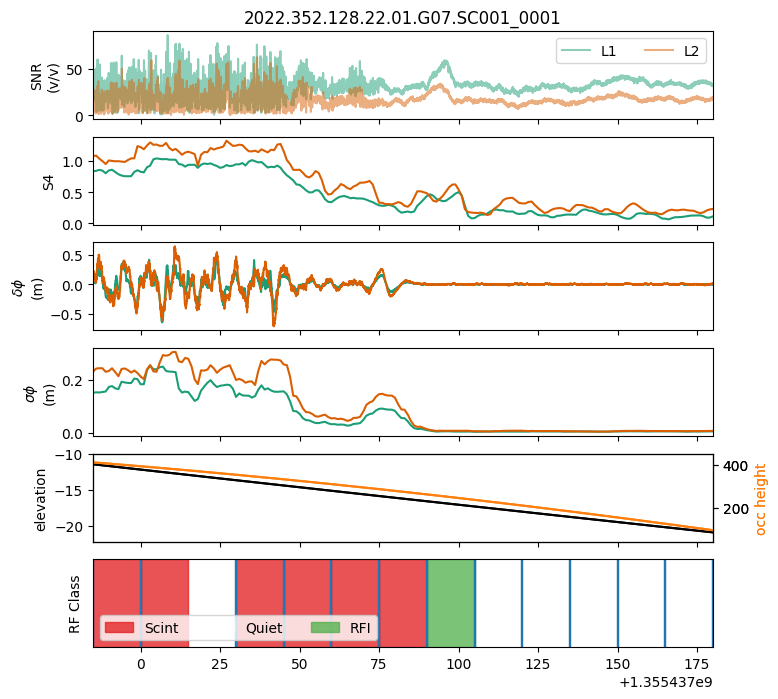

In [42]:
load_plot_multi(iono_rfi_li[2])

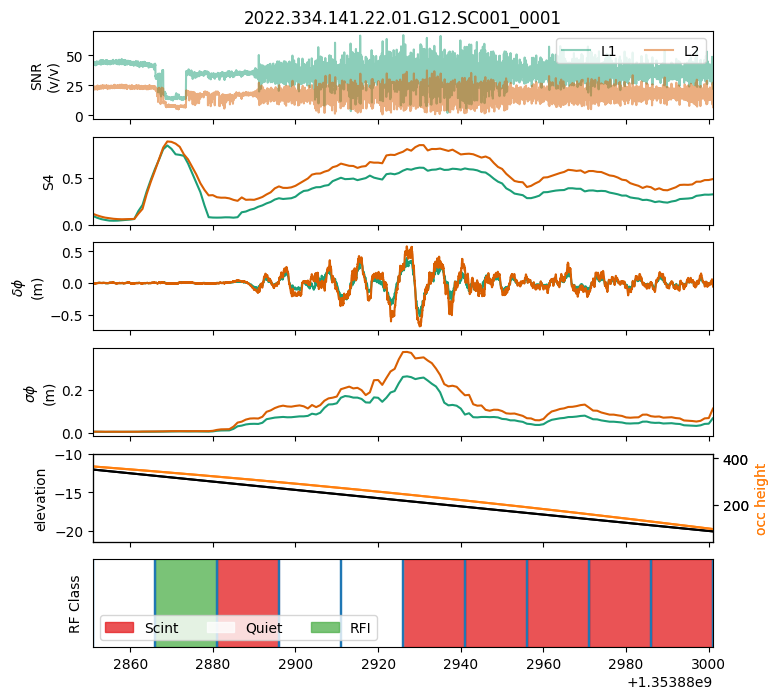

In [43]:
load_plot_multi(iono_rfi_li[52])

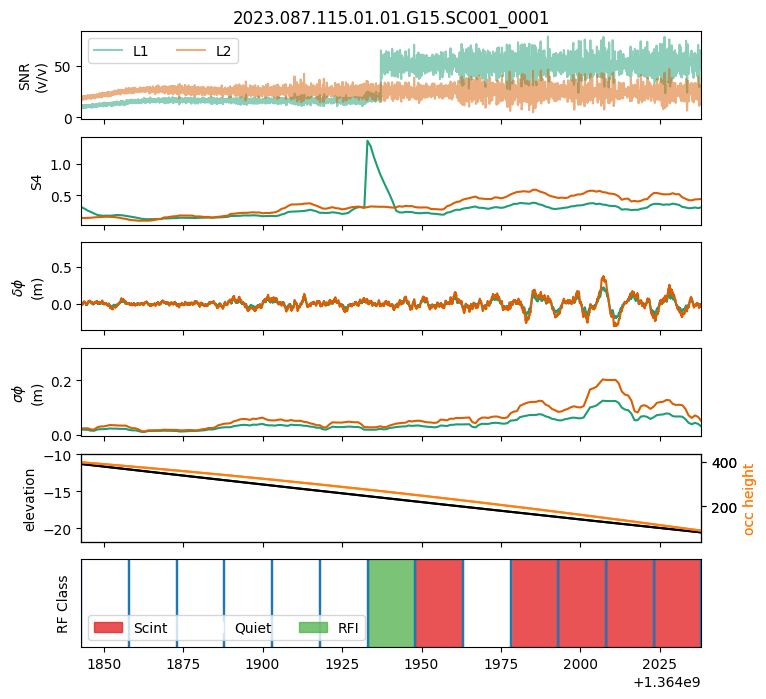

In [44]:
load_plot_multi(iono_rfi_li[56])

/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/numpy/lib/nan

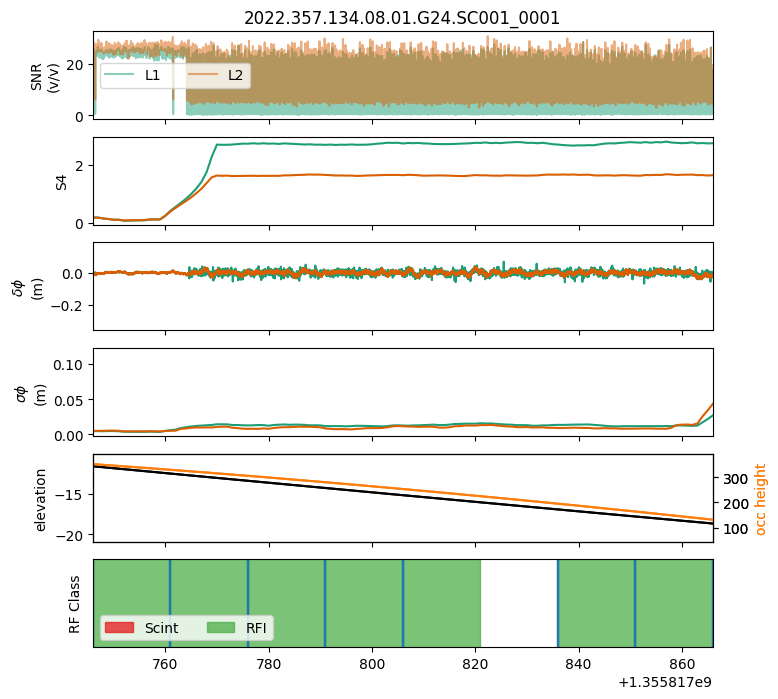

In [45]:
load_plot_multi(iono_rfi_li[3])

# for all non-downlink windows, count occurence of RFI

In [47]:
#Create list of all profiles, drop dups
all_files_list=list(set(all_files_f))

#list of all profiles used in training (to remove)

#list of all downlink profiles comms_file_li
#drop duplicates
comms_file_li=list(set(comms_file_li))

rfi_no_dl = list(set(all_files_list) - set(comms_file_li))


In [48]:
fdf_li=[]
for filez in rfi_no_dl[:]:
    #print(row['c1'], row['c2'])
    fn="../data/feature_sets_all/%s" %filez
    #print(fn)
    
    try:
        fdf=pd.read_pickle(fn)
        if fdf.shape[1]==63:
            fdf['sample']=len(fdf)*[sample]
            fdf_li+=[fdf]
        else:
            print(fn, fdf.shape[1])
        #print(i)
    except:
        pass
all_fdf=pd.concat(fdf_li, axis=0, ignore_index=True)

X, y, feature_names, fs_dict=df_2_Xy(all_fdf)

version="7"
from joblib import dump, load
rf_model=load( '../models/%s_rf-model.joblib' %version)


#--- test model
y_pred = rf_model.predict(X)
#print(y_pred)
unique, counts = np.unique(y_pred, return_counts=True)
count_dict=dict(zip(unique, counts))
print(count_dict)

{0.0: 136170, 1.0: 333548, 2.0: 5079, 3.0: 9479, 4.0: 30551}


In [49]:
for keyz in list(count_dict.keys()):
    print('label',keyz, ':', count_dict[keyz]/len(y_pred))

label 0.0 : 0.26449661731028096
label 1.0 : 0.6478836580055047
label 2.0 : 0.009865449947263839
label 3.0 : 0.01841201024810276
label 4.0 : 0.05934226448884771


In [34]:
sum(y_pred==2)/len(y_pred)

0.012196330029310818

/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


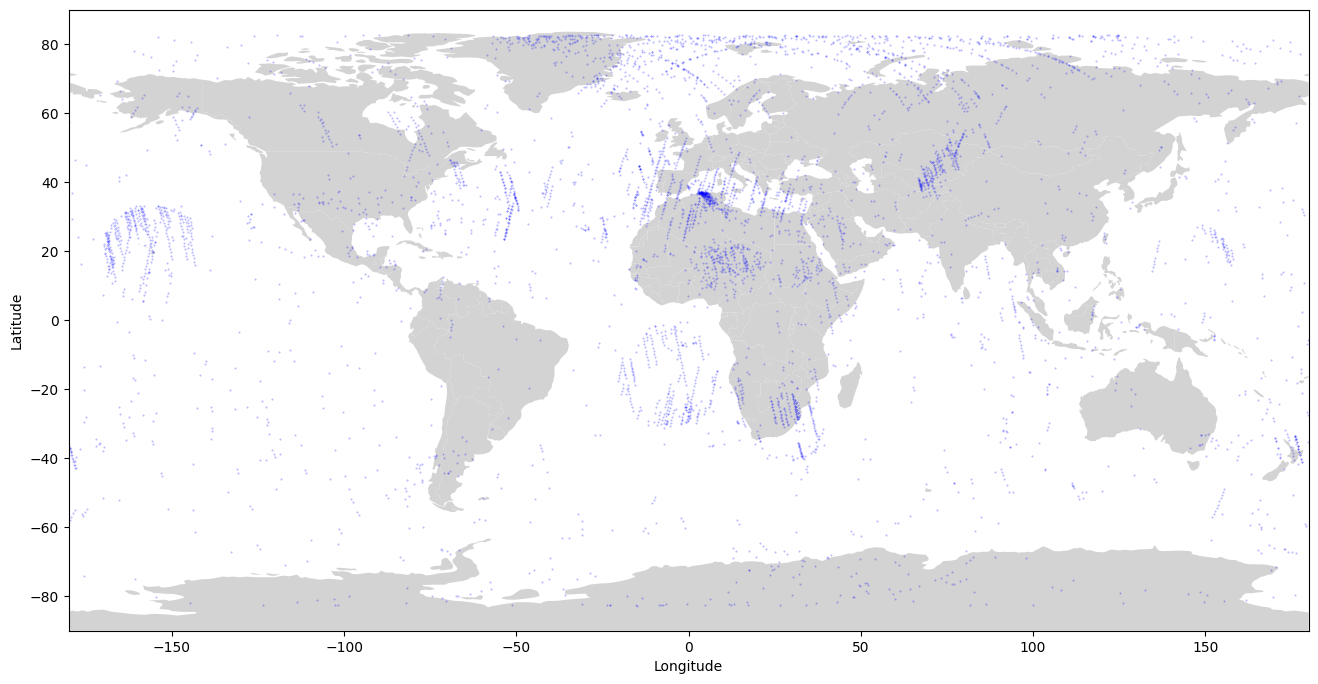

In [50]:
map_condition(fs_dict['lon_m'], fs_dict['lat_m'], y_pred, 2)

/home/stdi2687/gnss-leo-data/.venv/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


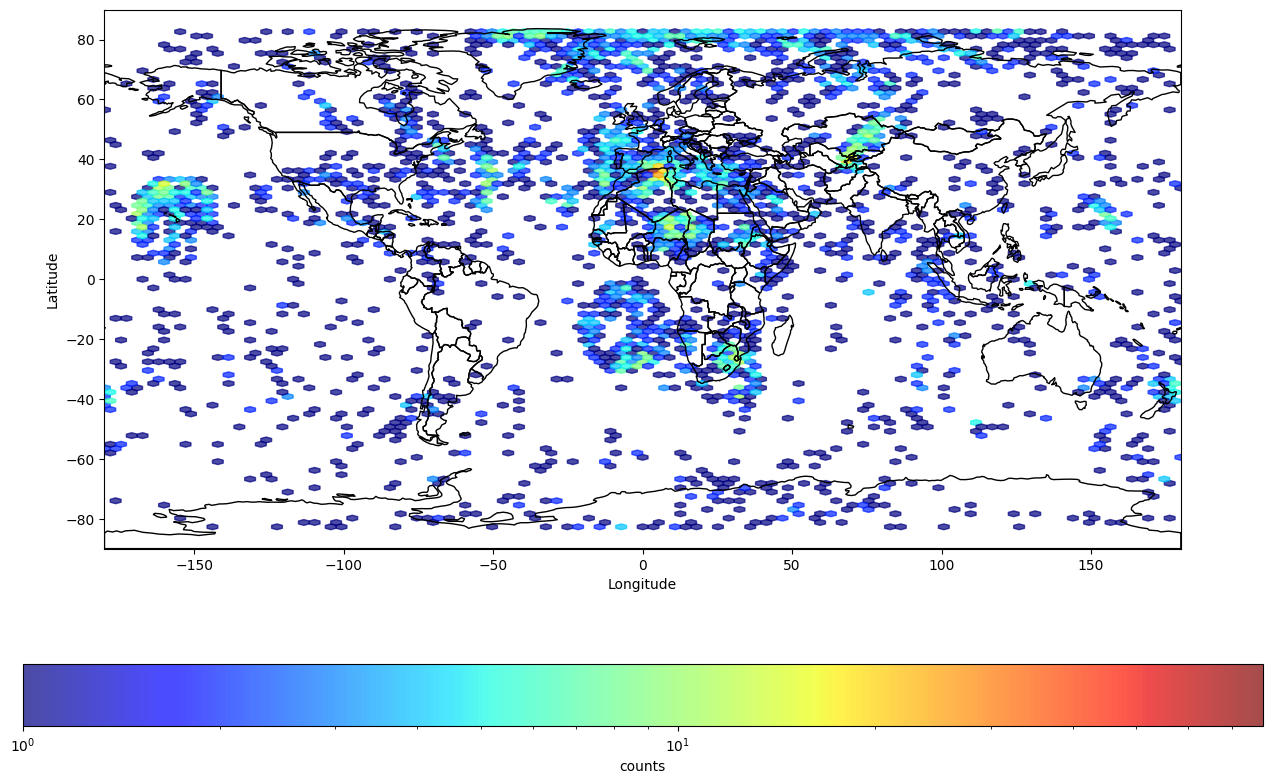

In [55]:
import geopandas as gpd

condition_val=2
#https://medium.com/@kavee625/plotting-data-on-the-world-map-with-geopandas-f03742615196
import matplotlib.pyplot as plt
# Getting world map data from geo pandas
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(16, 10))

#worldmap.plot(color="lightgrey", ax=ax)

# Plotting tourist source markets
x = fs_dict['lon_m'][y_pred==condition_val]
y = fs_dict['lat_m'][y_pred==condition_val]
#z = df['spireid']

bins=np.logspace(0, 2, num=20)+5
bins='log'
hb = ax.hexbin(x, y, gridsize=100, bins=bins, mincnt=0,  cmap='jet', alpha=.7) #bins='log',
worldmap.plot(facecolor="none", ax=ax, edgecolor='black')

#plt.clim(5,100)
#ax.set(xlim=xlim, ylim=ylim)
#ax.set_title("Hexagon binning")
cb = fig.colorbar(hb, ax=ax, label='counts',location='bottom')
#base = worldmap.plot(color='white', edgecolor='black')

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])

#plt.title("Tourist arrivals from main countries to Sri Lanka\n  Year : 2021")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()